In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, mean_squared_error

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 312)

In [27]:
data = pd.read_csv('HR_data.csv').drop([104, 120, 122, 125, 272])
X_data = data[['HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std', 'HR_TD_Min',
       'HR_TD_Max', 'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew',
       'HR_TD_Slope_min', 'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope',
       'TEMP_TD_Mean', 'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min',
       'TEMP_TD_Max', 'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew',
       'TEMP_TD_Slope_min', 'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean',
       'TEMP_TD_Slope', 'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std',
       'EDA_TD_P_Min', 'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis',
       'EDA_TD_P_Skew', 'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max',
       'EDA_TD_P_Slope_mean', 'EDA_TD_P_Slope', 'EDA_TD_T_Mean',
       'EDA_TD_T_Median', 'EDA_TD_T_std', 'EDA_TD_T_Min', 'EDA_TD_T_Max',
       'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis', 'EDA_TD_T_Skew',
       'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max', 'EDA_TD_T_Slope_mean',
       'EDA_TD_T_Slope', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT', 'EDA_TD_P_ReT',
       'Round', 'Phase', 'Individual', 'Puzzler', 'Cohort']]
feature_names = X_data.columns
y_string = ['Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired', 'nervous', 'determined', 'attentive', 'afraid', 'active' ]
y_data = data[y_string]
y_data.max()

Frustrated    8.0
upset         4.0
hostile       3.0
alert         5.0
ashamed       4.0
inspired      5.0
nervous       3.0
determined    5.0
attentive     5.0
afraid        3.0
active        5.0
dtype: float64

In [28]:
def encoding(X, y, type = 'ordinal'):
    X = X.copy()
    y = y.copy()
    if type == 'dummy':
        X = pd.get_dummies(X, columns=['Round', 'Phase', 'Individual', 'Cohort']).astype('int')
    elif type == 'ordinal':
        pass
        round_mapping = {'round_1': 1, 'round_2': 2, 'round_3': 3, 'round_4': 4}
        cohort_mapping = {'D1_1': 1, 'D1_2': 2, 'D1_3': 3, 'D1_4': 4, 'D1_5': 5, 'D1_6': 6}
        phase_mapping = {'phase1': 1, 'phase2': 2, 'phase3': 3}

        X['Round'] = X['Round'].map(round_mapping)
        X['Cohort'] = X['Cohort'].map(cohort_mapping)
        X['Phase'] = X['Phase'].map(phase_mapping)


    y['Frustrated'] = (y['Frustrated'] - 0.5)/10

    for col in y.columns:
        if col != 'Frustrated':
            transformed_col = (y[col] - 0.5) / 6
            y[col] = transformed_col

            
    return X, y



In [35]:
def GridSearch_random_forest(param_grid, X, y):
    random_forest = RandomForestRegressor()
    grid_search = GridSearchCV(random_forest, param_grid, cv=10, n_jobs=-1)

    grid_search.fit(X, y)
    
    return grid_search.best_estimator_


In [38]:
param_grid_random_forest = {
    'n_estimators': np.arange(1, 201, 10),  # Antal træer i skoven
    'max_depth': np.arange(1, 10),  # Maksimal dybde af træerne i skoven

}
"""     'min_samples_split': [2, 5, 10],  # Minimum antal samples krævet for at splitte en node
'min_samples_leaf': [1, 2, 4]  # Minimum antal samples krævet på et blad """

emotion = 'ashamed'

X, y = encoding(X_data, y_data)

y.head()
#bedste_model_adaboost = GridSearch_adaboost(param_grid_adaboost, emotion, X, y)
best_model_random_forest = GridSearch_random_forest(param_grid_random_forest, X, y[emotion])

RandomForestRegressor(max_depth=1, n_estimators=11)
{'n_estimators': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131, 141, 151, 161, 171, 181, 191]), 'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}


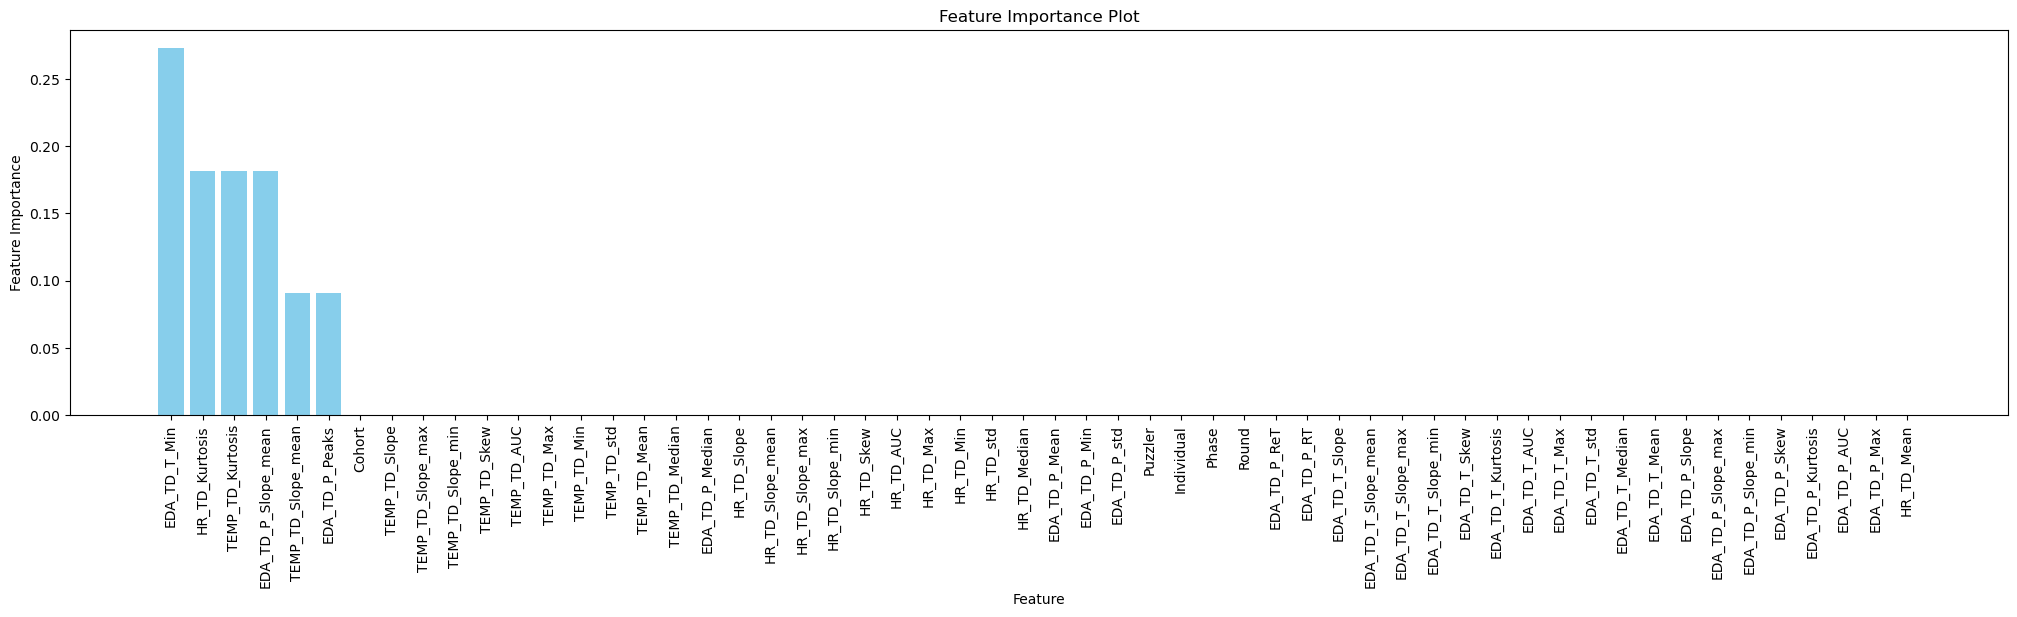

In [42]:
print(best_model_random_forest)
print(param_grid_random_forest)
best_model_random_forest.fit(X, y[emotion])

importances = best_model_random_forest.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
features_sorted = feature_names[sorted_indices]


plt.figure(figsize=(25, 5))
plt.bar(np.arange(len(features_sorted)), sorted_importances, color='skyblue')
plt.ylabel('Feature Importance')
plt.xlabel('Feature')
plt.title(f'Feature Importance Plot')
plt.xticks(np.arange(len(features_sorted)), features_sorted, rotation=90) 
plt.show()

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y[emotion], test_size=0.3)
best_model_random_forest.fit(X_train, y_train)
best_model_random_forest.predict(X_test)
# Få forudsigelser fra testdata
y_pred = best_model_random_forest.predict(X_test)

# Beregn MAE
error = mean_squared_error(y_test, y_pred)
print(error)

0.009368292682685068
